<a href="https://colab.research.google.com/github/pharringtonp19/mecon/blob/main/notebooks/practice_final/RTC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [142]:
#@title **Imports** { display-mode: "form" }
import jax 
import jax.numpy as jnp 
from functools import partial 
from dataclasses import dataclass
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [91]:
#@title **Probability of Paying** { display-mode: "form" }
def prob_pay(renter_type, amt): 
  score = jax.nn.sigmoid(10.*(renter_type-0.3)) + (2000-amt)/4000 
  annual_rate = jnp.minimum(score, 1.)
  monthly_rate = annual_rate**(1/12)
  return monthly_rate

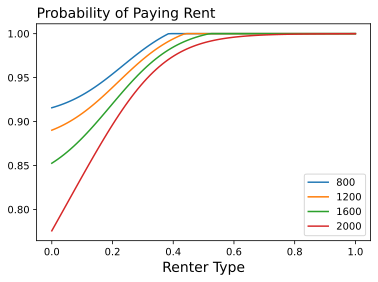

In [92]:
#@title **Plot Probability of Paying** { display-mode: "form" }
ts = jnp.linspace(0., 1., 100) # Vector of renter types 
amounts = [800, 1200, 1600, 2000]

for a in amounts:                     # Loop over amounts 
  f = partial(prob_pay, amt=a)        # Partially apply function
  f_vec = jax.vmap(f)                 # Vectorize function 
  ps = f_vec(ts)                      # Probability of paying amount 
  plt.plot(ts, ps, label=a)
plt.title('Probability of Paying Rent', loc='left', size=14)
plt.xlabel('Renter Type', size=14)
plt.legend()
plt.show()

In [93]:
#@title **Max Security Deposit** { display-mode: "form" }
def max_security_deposit(renter_type):
  return 1200.0 + 2000.0*renter_type 

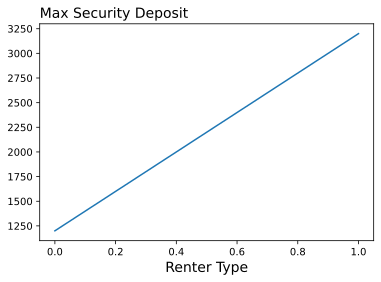

In [94]:
#@title **Plot Max Security Deposit** { display-mode: "form" }

rs = jnp.linspace(0, 1, 100)
max_deposit = max_security_deposit(rs)
plt.plot(rs, max_deposit)
plt.title('Max Security Deposit', loc='left', size=14)
plt.xlabel('Renter Type', size=14)
plt.show()

In [95]:
def value(n, security_deposit, monthly_rate):
  

SyntaxError: ignored

In [151]:
@dataclass 
class State: 
  rtc: int 
  landlord_income: float 
  occ_status: bool 
  renter_type: float 

In [152]:
def simulate(init_state, key, security_deposit, monthly_rate):

  def update_occupied(state, key):
    p = prob_pay(state.renter_type, monthly_rate)
    paid_rent = jax.random.bernoulli(jax.random.PRNGKey(0), p)
    change_income = jnp.where(paid_rent, monthly_rate, -(1+ rtc)*monthly_rate)
    return State(rtc, landlord_income + change_income, occ_status, renter_type)
  
  def update_unoccupied(state, key):
    (rtc, landlord_income, occ_status, renter_type) = state
    subkey1, subkey2 = jax.random.split(key)
    renter_type = jax.random.uniform(subkey1)
    indicator = (max_security_deposit(renter_type) > security_deposit)
    return State(rtc, landlord_income + jnp.where(indicator, security_deposit, 0.0), indicator, renter_type)

  def update(state, key):
    (rtc, landlord_income, occ_status, renter_type) = state
    new_state1 = update_occupied(state, key)
    print(type(new_state1))
    new_state2 = update_unoccupied(state, key)
    a = new_state1 if occ_status>0.5 else new_state2
    return a


  state = init_state 
  for i in range(5):
    key, _ = jax.random.split(key)
    state = update(state, key)
    print(state)

  #a, b = jax.lax.scan(update, state, xs=jax.random.split(key, 100))
  #return 

In [153]:
state = (0, 1000.0, False, 0.0)
print(state)

(0, 1000.0, False, 0.0)


In [154]:
simulate(state, jax.random.PRNGKey(0), 1000, 1200)

<class '__main__.State'>
State(rtc=0, landlord_income=DeviceArray(2000., dtype=float32, weak_type=True), occ_status=DeviceArray(True, dtype=bool), renter_type=DeviceArray(0.79038227, dtype=float32))


TypeError: ignored